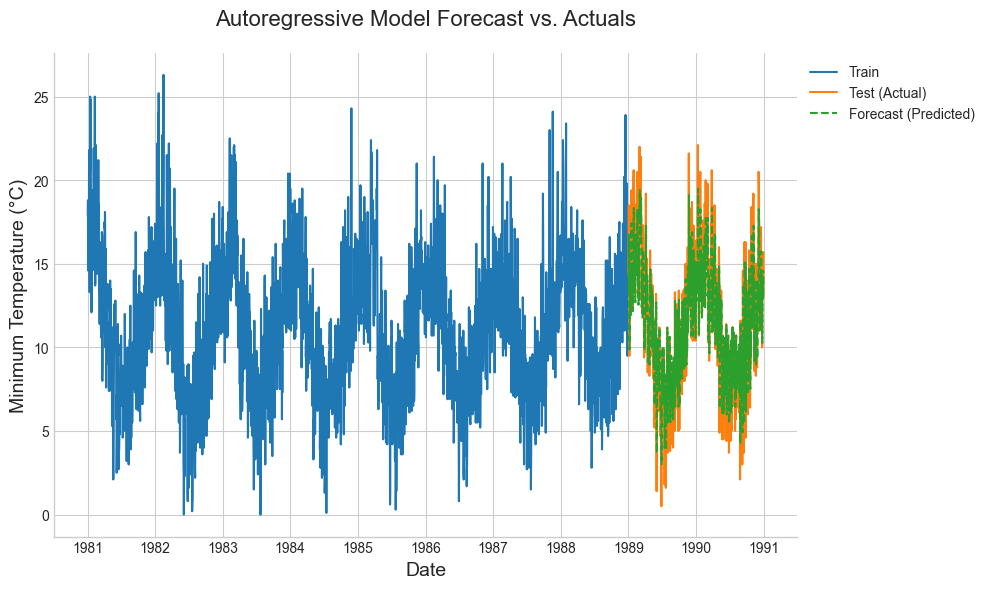

Root Mean Squared Error (RMSE): 2.38


In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset directly from the URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# --- 1. Data Preparation for Autoregression ---
# Create a new dataframe for the supervised learning problem
df_supervised = pd.DataFrame()
# Input sequence (t) from the 'Temp' column
df_supervised['t'] = df['Temp'].shift(1)
# Output sequence (t+1) from the 'Temp' column
df_supervised['t+1'] = df['Temp']
# Drop rows with NaN values (the first row)
df_supervised = df_supervised.dropna()

# Define features (X) and target (y)
X = df_supervised[['t']]
y = df_supervised['t+1']


# --- 2. Train-Test Split (Chronological) ---
split_point = int(len(X) * 0.80)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]


# --- 3. Model Training ---
model = LinearRegression()
model.fit(X_train, y_train)


# --- 4. Forecasting & Evaluation ---
# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))


# --- 5. Plotting Results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training, test (actual), and forecasted values
ax.plot(y_train.index, y_train.values, label='Train', color='tab:blue')
ax.plot(y_test.index, y_test.values, label='Test (Actual)', color='tab:orange')
ax.plot(y_test.index, predictions, label='Forecast (Predicted)', color='tab:green', linestyle='--')

# Formatting the plot
ax.set_title('Autoregressive Model Forecast vs. Actuals', fontsize=16, pad=20)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Minimum Temperature (°C)', fontsize=14)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print the final RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Using Cross Validation

RMSE scores for each of the 5 folds: [2.64 2.62 2.51 2.54 2.41]
Average RMSE: 2.54
Standard Deviation of RMSE: 0.08


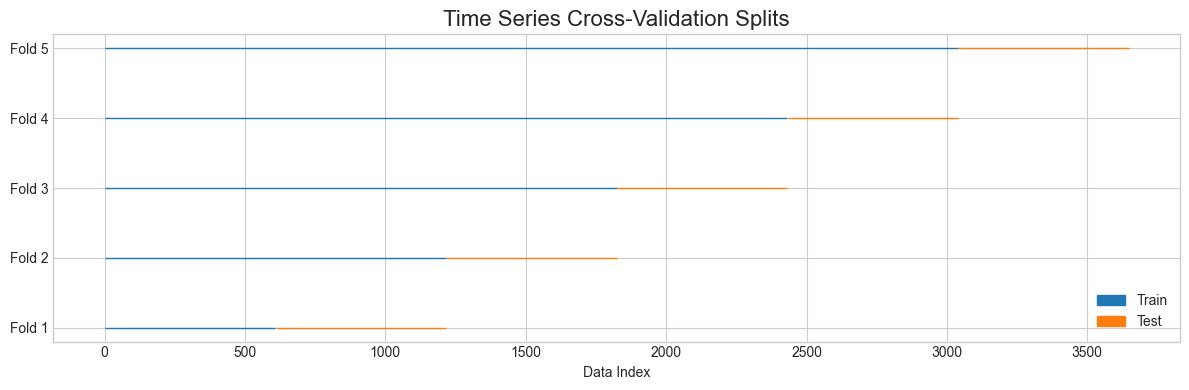

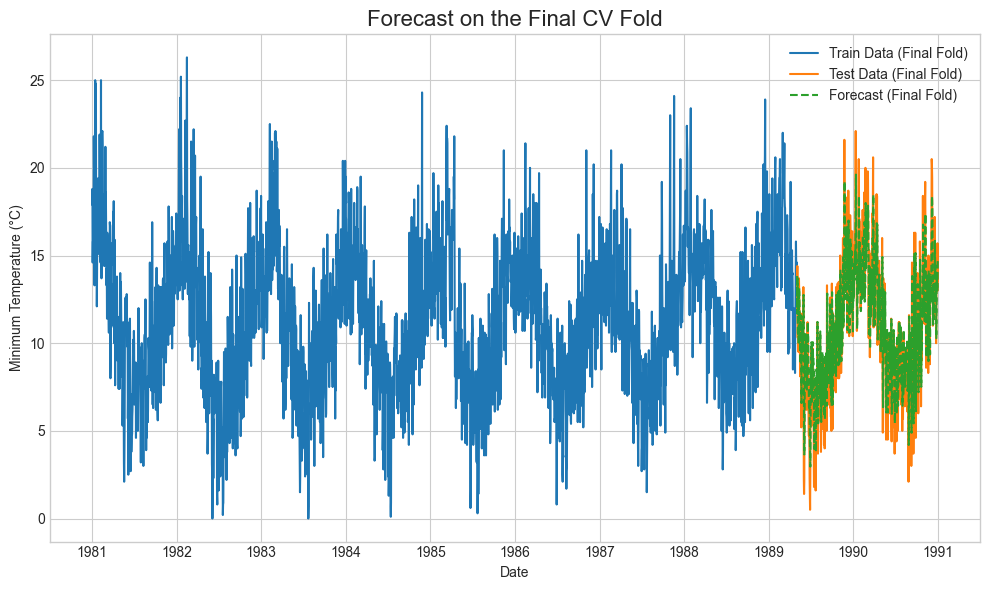

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Load the dataset directly from the URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# --- 1. Data Preparation for Autoregression ---
df_supervised = pd.DataFrame()
df_supervised['t'] = df['Temp'].shift(1)
df_supervised['t+1'] = df['Temp']
df_supervised = df_supervised.dropna()

X = df_supervised[['t']]
y = df_supervised['t+1']

# --- 2. Time Series Cross-Validation ---
# Use 5 splits. Test set size will be determined by the split logic.
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

rmse_scores = []

# Loop through each split
for train_index, test_index in tscv.split(X):
    # Get the training and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate and store RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_scores.append(rmse)

# --- 3. Report Results ---
print(f"RMSE scores for each of the {n_splits} folds: {np.round(rmse_scores, 2)}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Standard Deviation of RMSE: {np.std(rmse_scores):.2f}")


# --- 4. Visualization of the Splits ---
fig, ax = plt.subplots(figsize=(12, 4))
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Plot training and test indices as horizontal bars
    ax.fill_betweenx(y=[i], x1=train_index[0], x2=train_index[-1], color='tab:blue', label='Train' if i == 0 else "")
    ax.fill_betweenx(y=[i], x1=test_index[0], x2=test_index[-1], color='tab:orange', label='Test' if i == 0 else "")

ax.set_yticks(range(n_splits))
ax.set_yticklabels([f'Fold {i+1}' for i in range(n_splits)])
ax.set_title('Time Series Cross-Validation Splits', fontsize=16)
ax.set_xlabel('Data Index')
ax.legend()
plt.tight_layout()
plt.show()

# --- 5. Visualization of the Final Fold Forecast ---
# Retrieve the last fold's data and predictions for plotting
final_train_index, final_test_index = list(tscv.split(X))[-1]
X_train_final, X_test_final = X.iloc[final_train_index], X.iloc[final_test_index]
y_train_final, y_test_final = y.iloc[final_train_index], y.iloc[final_test_index]

# Retrain on the final training fold
model.fit(X_train_final, y_train_final)
final_predictions = model.predict(X_test_final)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y_train_final.index, y_train_final, label='Train Data (Final Fold)', color='tab:blue')
ax.plot(y_test_final.index, y_test_final, label='Test Data (Final Fold)', color='tab:orange')
ax.plot(y_test_final.index, final_predictions, label='Forecast (Final Fold)', color='tab:green', linestyle='--')
ax.set_title('Forecast on the Final CV Fold', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Minimum Temperature (°C)')
ax.legend()
plt.tight_layout()
plt.show()